# [作業目標]
- 使用 Day 12 剛學到的方法, 對較完整的資料生成離散化特徵
- 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
- 仿照 Day 12 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
- 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [1]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件
%matplotlib inline

# 設定 data_path
dir_data = '../data/'

### 之前做過的處理

In [2]:
# 讀取資料檔
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [3]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

## 練習時間
參考 Day 12 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [5]:
app_train["YEARS_BIRTH"] = app_train["DAYS_BIRTH"] / 365
corr_df = abs(app_train.corr()).loc["YEARS_BIRTH", "TARGET"]
print("R = ", corr_df)

R =  0.07823930831003233


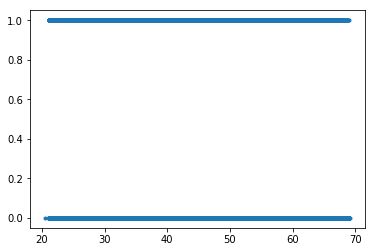

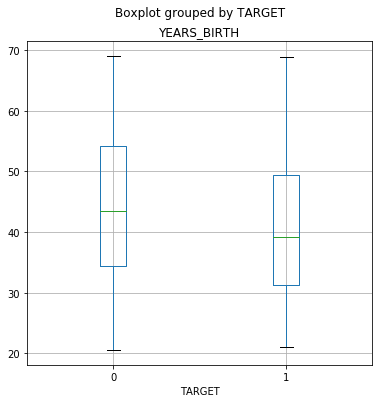

In [6]:
# 這邊看起來不是很清楚，頂多藉由Box plot感受起來延遲還款的年齡層比較低
plt.plot(app_train["YEARS_BIRTH"], app_train["TARGET"], ".")
app_train.boxplot(column = "YEARS_BIRTH", by = "TARGET", showfliers = False, figsize=(6,6))

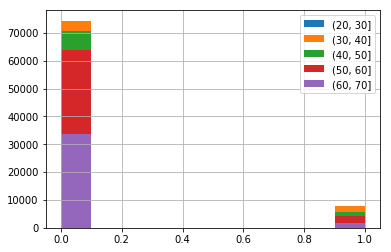

In [7]:
# 這邊看起來看起來 Target = 1 代表延遲還款的人，隨著年齡增加，似乎人數是越少的，這邊20-30歲的人看不太到，可能要確認一下
# 另外可能要算一下 延遲還款/準時還款 的一個比例
group = [20, 30, 40, 50, 60, 70]
app_train['YEARS_BINNED'] = pd.cut(app_train['YEARS_BIRTH'], bins = group)
app_train.groupby("YEARS_BINNED")["TARGET"].hist()
plt.legend(np.unique(app_train["YEARS_BINNED"]))

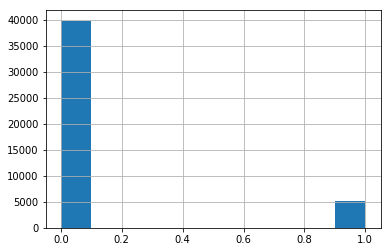

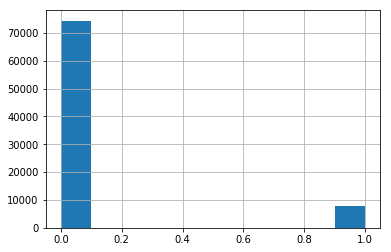

In [8]:
# 這邊發現20-30歲的比30-40歲的低，所以可能要想一下怎麼畫圖比較好
plt.figure()
app_train.loc[app_train["YEARS_BINNED"] == pd.Interval(20, 30, closed = "right"), "TARGET"].hist()
plt.figure()
app_train.loc[app_train["YEARS_BINNED"] == pd.Interval(30, 40, closed = "right"), "TARGET"].hist()

Text(0.5,1,'Target Counter in Different Ages')

<Figure size 432x288 with 0 Axes>

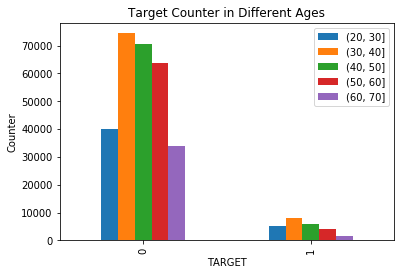

In [47]:
# 稍微重新整理一下，紀錄每個Group的Target = 1 or 0的數字
df_count = pd.DataFrame()
for group_factor, group_content in app_train.groupby("YEARS_BINNED"):
    df_count = df_count.append(pd.DataFrame([[np.sum(group_content["TARGET"] == 0), np.sum(group_content["TARGET"] == 1)]], columns = ["0", "1"], index = [group_factor]))
df_count = df_count.T.head()
plt.figure()
df_count.plot.bar()
plt.xlabel("TARGET")
plt.ylabel("Counter")
plt.title("Target Counter in Different Age Group")

# Test the DataFrame Operation
# df = pd.DataFrame([[1, 2, 3]], columns = ["0", "1", "2"], index = ["A"])
# df.head()

       (20, 30]      (30, 40]      (40, 50]    (50, 60]      (60, 70]
0  39863.000000  74420.000000  70685.000000  63890.0000  33828.000000
1   5158.000000   7888.000000   5856.000000   4172.0000   1751.000000
2      0.129393      0.105993      0.082846      0.0653      0.051762


Text(0,0.5,'Late Payment / On Time Payment')

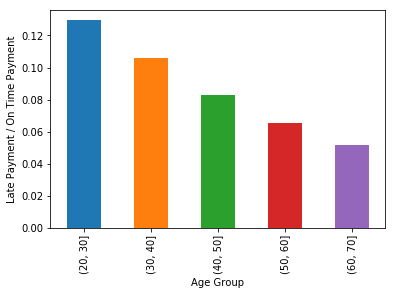

In [58]:
# 再算一下delay還款跟正常還款的比例(或是其實可以改成總人數中的比例)，看起來越高年齡的人準時還款能力越強
print(df_count.head())
df_count = df_count.append(df_count.iloc[1, :] / df_count.iloc[0, :], ignore_index = True)
plt.figure()
df_count.iloc[2, :].plot.bar()
plt.xlabel("Age Group")
plt.ylabel("Late Payment / On Time Payment")